In [1]:
from pcd_dataset import PointCloudDataset
from plane_detector import StructuralRANSAC
from semantic_segmentation import SemanticSegmentor
from s3dis_metrics import SegmentationMetrics
from pointnet_utils import PointnetInference
import yaml
import numpy as np
import wandb
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [2]:
FILE = "./data/full_scan.ply"

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [4]:
s_val = PointCloudDataset(FILE)

In [5]:
sem_seg = SemanticSegmentor(s_val, StructuralRANSAC, PointnetInference, config)

/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: divide by zero encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: overflow encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: invalid value encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T


In [6]:
# sem_seg.visualize_pcd()

In [7]:
sem_seg.ransac_segment()

Starting structural segmentation...
Detecting floor and ceiling...
  Floor found: 220449 points
  Ceiling found: 121833 points
Segmentation complete in 7.12 seconds
Found: 2 structural elements
  floor: 1
  ceiling: 1
Remaining unsegmented points: 796897


In [8]:
sem_seg.ransac_segmentor.visualize_segments()

PointCloud with 1139179 points.

In [8]:
n = sem_seg.ransac_segmentor.segments["ceiling"]["plane"]["normal"]
target = np.array([0., 0., -1.])
angle = np.degrees(np.arccos(np.clip(np.abs(np.dot(n, target)), -1, 1)))
angle

np.float64(0.682281103433424)

In [9]:
all_idx = np.arange(len(sem_seg.pcd.points))
mask = np.ones_like(all_idx, dtype=bool)
mask[sem_seg.ransac_segmentor.segments["floor"]["indices"]] = False
mask[sem_seg.ransac_segmentor.segments["ceiling"]["indices"]] = False
pcd_no_fc = sem_seg.pcd.select_by_index(all_idx[mask])

In [14]:
remaining_indices = sem_seg.ransac_segmentor.remaining_indices

In [28]:
pcd_no_fc

PointCloud with 796897 points.

In [29]:
from scipy.spatial import cKDTree
from sklearn.cluster import DBSCAN

def region_growing_planes(pcd, normal_angle_thresh=np.deg2rad(10), radius=0.1, min_cluster_size=500):
    pts = np.asarray(pcd.points)
    normals = np.asarray(pcd.normals)
    tree = cKDTree(pts)
    
    # Start from all points
    unvisited = np.ones(len(pts), dtype=bool)
    clusters = []
    
    for seed_idx in range(len(pts)):
        if not unvisited[seed_idx]:
            continue
        
        cluster = [seed_idx]
        queue = [seed_idx]
        unvisited[seed_idx] = False
        n_seed = normals[seed_idx]
        
        while queue:
            i = queue.pop()
            # find neighbors within radius
            neighbors = tree.query_ball_point(pts[i], radius)
            for j in neighbors:
                if unvisited[j]:
                    n_j = normals[j]
                    angle = np.arccos(np.clip(np.dot(n_seed, n_j), -1, 1))
                    if angle < normal_angle_thresh:
                        unvisited[j] = False
                        queue.append(j)
                        cluster.append(j)
        if len(cluster) >= min_cluster_size:
            clusters.append(cluster)
    
    print(f"Found {len(clusters)} clusters")
    return clusters

In [30]:
def fit_plane(pts):
    centroid = pts.mean(axis=0)
    _, _, vh = np.linalg.svd(pts - centroid)
    normal = vh[-1]
    d = -np.dot(normal, centroid)
    return normal, d

In [31]:
clusters = region_growing_planes(pcd_no_fc, radius=0.05, min_cluster_size=800)

planes = []
for c in clusters:
    pts_c = np.asarray(pcd_no_fc.points)[c]
    n, d = fit_plane(pts_c)
    planes.append({'normal': n, 'd': d, 'indices': c})

Found 86 clusters


In [16]:
vis = [pcd_no_fc.select_by_index(i["indices"]) for i in planes]

In [17]:
o3d.visualization.draw_geometries(vis)

In [32]:
g = np.array([0, 0, 1])  
classified = {"floor": [], "ceiling": [], "wall": [], "object": []}

for i, cl in enumerate(planes):  # each cluster you fitted
    n = cl["normal"] / np.linalg.norm(cl["normal"])
    dot = abs(np.dot(n, g))
    if dot > 0.9:
        # nearly horizontal
        if cl["normal"][2] < 0: classified["ceiling"].append(i)
        else: classified["floor"].append(i)
    elif dot < 0.1:
        classified["wall"].append(i)
    else:
        classified["object"].append(i)

In [33]:
def classify_and_filter_patches(patches, pcd_points, floor_z, ceiling_z,
                                vertical_tol=0.2,   # |n·z| < 0.2 → vertical
                                height_frac=0.6,    # keep if ≥60% room height
                                min_area=0.3):      # m² threshold
    room_height = ceiling_z - floor_z
    kept = []
    stats = []

    for i, p in enumerate(patches):
        n = p["normal"] / np.linalg.norm(p["normal"])
        nz = abs(n[2])
        pts = pcd_points[p["indices"]]
        height_span = pts[:,2].max() - pts[:,2].min()

        # approximate planar area (ellipse via PCA)
        _, s, _ = np.linalg.svd(pts - pts.mean(0))
        area = np.pi * s[0] * s[1]

        stats.append({
            "id": i,
            "nz": nz,
            "height_span": height_span,
            "area": area
        })

        if (nz < vertical_tol and
            height_span > height_frac * room_height and
            area > min_area):
            kept.append({
                "id": i,
                **p,
                "height_span": height_span,
                "area": area,
                "centroid": pts.mean(0)
            })

    print(f"Kept {len(kept)} / {len(patches)} patches as wall candidates.")
    return kept, stats

In [35]:
vis = [pcd_no_fc.select_by_index(i["indices"]) for i in np.array(planes)[vertical_candidates]]

In [36]:
o3d.visualization.draw_geometries(vis)

In [34]:
ceiling_plane_height = sem_seg.ransac_segmentor.get_ceiling_height()
floor_plane_height = sem_seg.ransac_segmentor.get_floor_height()

In [35]:
vertical_candidates = classified["wall"]
filtered_patches, stats = classify_and_filter_patches(
    np.array(planes)[vertical_candidates], np.asarray(pcd_no_fc.points),
    floor_z=floor_plane_height,
    ceiling_z=ceiling_plane_height)

Kept 53 / 76 patches as wall candidates.


In [22]:
from sklearn.cluster import DBSCAN

def merge_coplanar_patches(patches, pcd_points,
                           voxel_size,
                           merge_angle_deg=5.0,
                           merge_dist_multiplier=3.0,
                           adjacency_dist=0.25):
    """
    patches: filtered vertical patches (dicts with 'normal','d','indices')
    returns: list of merged wall dicts
    """
    if not patches:
        return []

    # 1️⃣ feature space = (nx,ny,d)
    ns = np.array([p["normal"][:2]/np.linalg.norm(p["normal"][:2]) for p in patches])
    ds = np.array([p["d"] for p in patches]).reshape(-1,1)
    X = np.hstack([ns, ds/(merge_dist_multiplier*voxel_size)])

    db = DBSCAN(eps=0.12, min_samples=1).fit(X)
    labels = db.labels_

    merged = []
    for lab in np.unique(labels):
        members = np.where(labels==lab)[0]
        all_idx = np.unique(np.concatenate([patches[m]["indices"] for m in members]))
        pts = pcd_points[all_idx]
        # refit plane (least-squares)
        c = pts.mean(0)
        _, _, vh = np.linalg.svd(pts - c)
        n = vh[-1]
        if n[2] < 0: n = -n
        d = -np.dot(n, c)
        merged.append(dict(label=int(lab),
                           normal=n,
                           d=float(d),
                           indices=all_idx,
                           centroid=c))
    print(f"Merged → {len(merged)} wall planes (from {len(patches)} patches)")
    return merged

In [23]:
merged_walls = merge_coplanar_patches(
    filtered_patches, np.asarray(pcd_no_fc.points),
    voxel_size=config["subsample_ratio"])

Merged → 49 wall planes (from 53 patches)


In [24]:
vis = [pcd_no_fc.select_by_index(i["indices"]) for i in merged_walls]

In [25]:
o3d.visualization.draw_geometries(vis)

In [28]:
def visualize_patch_filtering(pcd, patches, kept_indices, point_alpha=0.9):
    """
    Show kept vs rejected planar patches in different colors.
    pcd: full Open3D point cloud
    patches: list of dicts, each with 'indices'
    kept_indices: list of integer patch indices (kept for walls)
    """
    kept_color = np.array([0.0, 0.8, 0.0])   # green
    rejected_color = np.array([0.7, 0.7, 0.7])  # gray

    geoms = []
    for i, p in enumerate(patches):
        sub = pcd.select_by_index(p["indices"])
        if i in kept_indices:
            sub.paint_uniform_color(kept_color)
        else:
            sub.paint_uniform_color(rejected_color)
        geoms.append(sub)

    print(f"Displaying {len(kept_indices)} kept (green) and {len(patches) - len(kept_indices)} rejected (gray).")
    o3d.visualization.draw_geometries(geoms, window_name="Wall filtering sanity check")

In [29]:
kept_ids = [p["id"] for p in stats if p.get("id") is not None and any(p["id"] == fp.get("id") for fp in filtered_patches)]

In [50]:
visualize_patch_filtering(pcd_no_fc, np.array(planes)[vertical_candidates], kept_indices=kept_ids)

Displaying 20 kept (green) and 56 rejected (gray).


In [ ]:
pcd_no_fc

In [10]:
pn = PointnetInference()

In [16]:
sem_seg.points[remaining_indices]

array([[ 1.869049  , -1.846894  ,  0.008348  ,  0.53333333,  0.54509804,
         0.54509804],
       [ 3.614496  ,  2.082214  , -0.646989  ,  0.30980392,  0.21960784,
         0.14509804],
       [-0.346538  ,  2.15853   ,  0.941288  ,  0.60392157,  0.58431373,
         0.55686275],
       ...,
       [-0.2900115 , -1.9266115 , -0.231579  ,  0.52745098,  0.53137255,
         0.52352941],
       [-0.2920505 ,  3.1223255 , -0.302641  ,  0.61764706,  0.58627451,
         0.5627451 ],
       [ 7.173837  , -2.0341425 ,  0.4061155 ,  0.93921569,  0.90196078,
         0.87254902]], shape=(796897, 6))

In [17]:
data_blocks, block_indices = pn.create_pointnet_blocks(sem_seg.points[remaining_indices], config["block_size"], config["stride"])

In [19]:
all_predictions, all_confidences = pn.inference(data_blocks, type="all")

In [21]:
def reconstruct_labels_with_confidence(points, predictions, confidences, block_indices, num_classes=13, type="all"):
    """
    Weighted voting reconstruction that returns both labels and per-point confidence.
    Confidence = normalized vote weight of the winning class.
    """
    num_points = len(points)
    vote_weights = np.zeros((num_points, num_classes), dtype=np.float32)

    for block_pred, block_conf, block_idx in zip(predictions, confidences, block_indices):
        for i, point_idx in enumerate(block_idx):
            if point_idx < num_points:
                cls = block_pred[i]
                conf = block_conf[i]
                vote_weights[point_idx, cls] += conf

    # compute labels
    point_labels = np.argmax(vote_weights, axis=1)
    total_votes = np.sum(vote_weights, axis=1)
    winning_votes = vote_weights[np.arange(num_points), point_labels]

    # normalized confidence of the chosen class
    point_confidences = np.divide(
        winning_votes, total_votes,
        out=np.zeros_like(winning_votes), where=total_votes > 0
    )

    # handle no-vote points
    no_votes_mask = total_votes == 0
    if type == "wall":
        point_labels[no_votes_mask] = 2
    else:
        point_labels[no_votes_mask] = 12

    point_confidences[no_votes_mask] = 0.0

    return point_labels, point_confidences

In [22]:
point_labels, point_confidences = reconstruct_labels_with_confidence(
    sem_seg.points[remaining_indices],
    all_predictions,
    all_confidences,
    block_indices,
    num_classes=13,
    type="all"
)

In [23]:
point_labels

array([ 5, 12,  0, ...,  6, 10,  5], shape=(796897,))

In [24]:
point_confidences

array([1.        , 1.        , 0.8275256 , ..., 0.56369144, 0.41276413,
       1.        ], shape=(796897,), dtype=float32)

In [25]:
def add_semantic_to_patches(patches, point_labels, confidences, wall_class_idx=2):
    """Compute wall probability per patch based on semantic predictions."""
    for p in patches:
        idx = p["indices"]
        patch_labels = point_labels[idx]
        patch_conf   = confidences[idx]

        # wall probability = mean confidence for wall class
        wall_mask = (patch_labels == wall_class_idx)
        if np.sum(wall_mask) == 0:
            p["sem_wall_prob"] = 0.0
        else:
            p["sem_wall_prob"] = float(np.mean(patch_conf[wall_mask]))

        # fraction of wall points
        p["sem_wall_ratio"] = float(np.mean(wall_mask))

    return patches

In [39]:
filtered_patches = add_semantic_to_patches(filtered_patches, point_labels, point_confidences)

In [49]:
def compute_fused_score_no_color(patch_metrics,
                                 room_height,
                                 geom_weight=0.7,
                                 sem_weight=0.3,
                                 area_scale_reference=None):
    """
    Compute a fused score in [0,1] for a patch using ONLY geometry + semantics.

    Inputs
    - patch_metrics: dict for a single patch with keys at least:
        - "height_span"   : float (meters or consistent units)
        - "area"          : float (area measure; if units unusual, see area_scale_reference)
        - "sem_wall_prob" : float in [0,1] (mean semantic confidence for 'wall' points)  (optional)
        - "sem_wall_ratio": float in [0,1] (fraction of points labeled 'wall')          (optional)
      If semantic keys are missing, semantic contribution is treated as 0.

    - room_height: scalar (ceiling_z - floor_z) in same units as height_span.
    - geom_weight: weight for geometry term (0..1)
    - sem_weight: weight for semantic term (0..1). geom_weight + sem_weight should be 1.0 normally.
    - area_scale_reference: If not None, expected typical wall area for normalization.
        If None, function will use a heuristic scale (log-based).

    Returns
    - fused_score: float in [0,1]
    """
    # ---------- Geometry term ----------
    # 1) Height fraction: how tall is the patch relative to the room
    h = float(patch_metrics.get("height_span", 0.0))
    # avoid divide-by-zero
    if room_height <= 0:
        h_norm = 0.0
    else:
        h_norm = np.clip(h / float(room_height), 0.0, 1.0)   # 0..1

    # 2) Area normalization:
    area = float(patch_metrics.get("area", 0.0))
    # Use a log-scale normalization so large differences don't dominate.
    # The divisor "4.0" maps roughly log10(area+1)=4 => a_norm=1 (i.e. area ~ 10^4 units)
    # If you know typical wall area scale (in m^2), pass it as area_scale_reference.
    if area_scale_reference is None:
        # robust log-normal scaling (works across different unit scales)
        a_norm = np.clip(np.log10(area + 1.0) / 4.0, 0.0, 1.0)
    else:
        # scale relative to provided reference area (linear)
        a_norm = np.clip(area / float(area_scale_reference), 0.0, 1.0)

    # Combine height + area into a geometry confidence (0..1)
    # Give equal importance to normalized height and normalized area by default.
    geom_conf = 0.5 * h_norm + 0.5 * a_norm

    # ---------- Semantic term ----------
    # Prefer sem_wall_prob if available; also use sem_wall_ratio if present.
    sem_prob = float(patch_metrics.get("sem_wall_prob", 0.0))
    sem_ratio = float(patch_metrics.get("sem_wall_ratio", 0.0))

    # Two sensible ways to combine them: weighted average or product.
    # Product penalizes patches where either prob or ratio is low.
    # Weighted average is more permissive.
    # Here we compute a robust combination:
    s_conf = 0.5 * sem_prob + 0.5 * sem_ratio   # in [0,1]

    # If both semantic fields missing, s_conf remains 0.0 (no semantic evidence).
    # ---------- Fuse final score ----------
    # Ensure weights sum to 1.0
    total_w = float(geom_weight + sem_weight)
    if total_w <= 0:
        total_w = 1.0
    gw = geom_weight / total_w
    sw = sem_weight / total_w

    fused_score = gw * geom_conf + sw * s_conf
    # clamp again for numerical safety
    fused_score = float(np.clip(fused_score, 0.0, 1.0))
    return fused_score

In [62]:
room_height = ceiling_plane_height - floor_plane_height
area_ref = np.percentile([p['area'] for p in filtered_patches], 75)

for p in filtered_patches:
    p['fused_score'] = compute_fused_score_no_color(
        p, room_height,
        geom_weight=0.5,
        sem_weight=0.5,
        area_scale_reference=area_ref
    )

# filter by score
kept_patches = [p for p in filtered_patches if p['fused_score'] > 0.55]
print(f"Kept {len(kept_patches)} / {len(filtered_patches)} after fused scoring.")

Kept 29 / 53 after fused scoring.


In [63]:
vis = [pcd_no_fc.select_by_index(i["indices"]) for i in kept_patches]

In [64]:
o3d.visualization.draw_geometries(vis)

In [65]:
wall_mask = point_labels == 2

In [66]:
wall_mask

array([False, False, False, ..., False, False, False], shape=(796897,))

In [72]:
sem_seg.pcd.select_by_index(remaining_indices[wall_mask])

PointCloud with 117441 points.

In [73]:
o3d.visualization.draw_geometries([sem_seg.pcd.select_by_index(remaining_indices[wall_mask])])

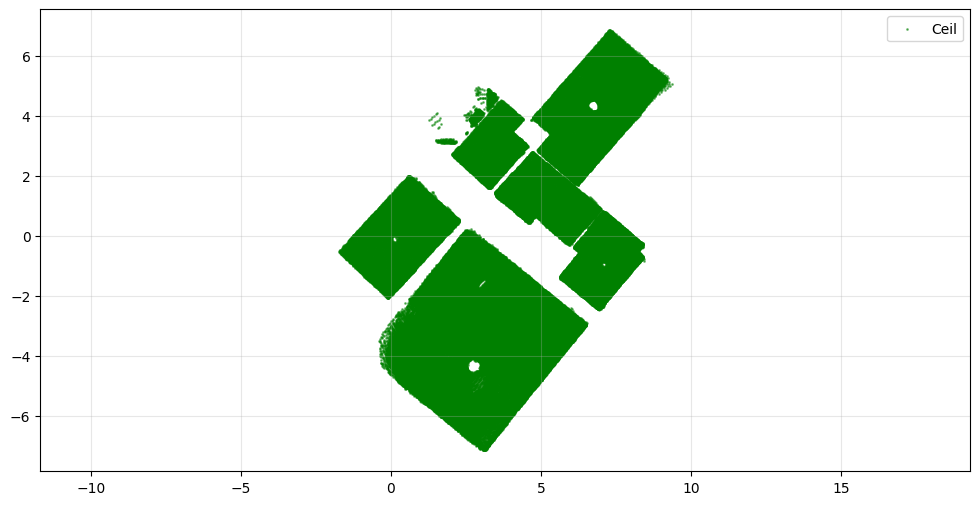

In [16]:
plt.figure(figsize=(12, 6))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1, label='Ceil', alpha=0.5)

plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [17]:
clustering = DBSCAN(eps=0.1, min_samples=5, algorithm='kd_tree', n_jobs=-1)  
ceiling_clusters = clustering.fit_predict(ceiling_points_2d)

In [18]:
n = len(set(ceiling_clusters)) - (1 if -1 in ceiling_clusters else 0)
print(f"Number of segments found: {n}")

Number of segments found: 7


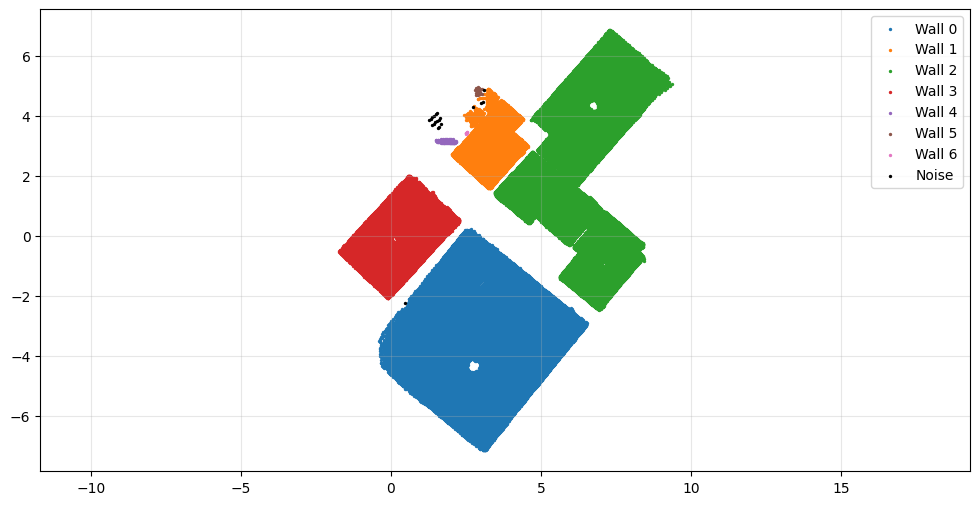

In [19]:
keep_clusters = []
plt.figure(figsize=(12, 6))
for cluster_id in set(ceiling_clusters):
    if cluster_id == -1:
        color = 'black'
        label = 'Noise'
    else:
        label = f'Wall {cluster_id}'
        color = None
    
    mask = ceiling_clusters == cluster_id
    if sum(mask) > 0:
        keep_clusters.append(cluster_id)
        plt.scatter(ceiling_points_2d[mask, 0], ceiling_points_2d[mask, 1], 
                    s=2, label=label, c=color if color else None)

plt.axis('equal')
plt.legend()

plt.grid(True, alpha=0.3)
plt.show()

In [20]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def segment_rooms_hierarchical(ceiling_2d, n_rooms=None, distance_threshold=1.0):
    """
    Use hierarchical clustering - better for rooms with narrow connections
    
    Args:
        ceiling_2d: Nx2 array of ceiling points
        n_rooms: Number of rooms (if known), or None
        distance_threshold: Distance to merge clusters
    """
    
    if n_rooms is not None:
        # If you know how many rooms
        clustering = AgglomerativeClustering(n_clusters=n_rooms)
        labels = clustering.fit_predict(ceiling_2d)
    else:
        # Let algorithm decide based on distance
        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=distance_threshold,
            linkage='ward'
        )
        labels = clustering.fit_predict(ceiling_2d)
    
    n_found = len(set(labels))
    print(f"Hierarchical clustering found {n_found} rooms")
    
    return labels

In [1]:
def detect_walls_ransac(pcd, gravity=np.array([0,0,1]),
                        dist_thresh=0.02,  # 2 cm tolerance
                        angle_thresh_deg=10,
                        min_inliers=2000,   # depends on your density
                        max_iter=20):

    walls = []
    remaining = pcd
    angle_thresh = np.deg2rad(angle_thresh_deg)

    for i in range(max_iter):
        if len(remaining.points) < min_inliers:
            break

        plane_model, inliers = remaining.segment_plane(
            distance_threshold=dist_thresh,
            ransac_n=3,
            num_iterations=1000
        )

        n = np.array(plane_model[:3])
        n /= np.linalg.norm(n)
        d = plane_model[3]

        # angle between normal and gravity
        angle = np.arccos(np.clip(np.abs(np.dot(n, gravity)), -1.0, 1.0))

        if abs(angle - np.pi/2) < angle_thresh:   # near-vertical plane
            walls.append({'normal': n, 'd': d, 'inliers': inliers})

        # remove inliers from cloud regardless
        mask = np.ones(len(remaining.points), dtype=bool)
        mask[inliers] = False
        remaining = remaining.select_by_index(np.where(mask)[0])

        if len(walls) > 20:
            break  # stop if too many planes found (optional)

    return walls

NameError: name 'np' is not defined

In [ ]:
labels

In [134]:
keep_clusters

[np.int64(0), np.int64(1), np.int64(3)]

In [146]:
mask = ceiling_clusters == keep_clusters[0]

In [147]:
sum(mask)

np.int64(22783)

In [148]:
coord = ceiling_points_2d[mask]

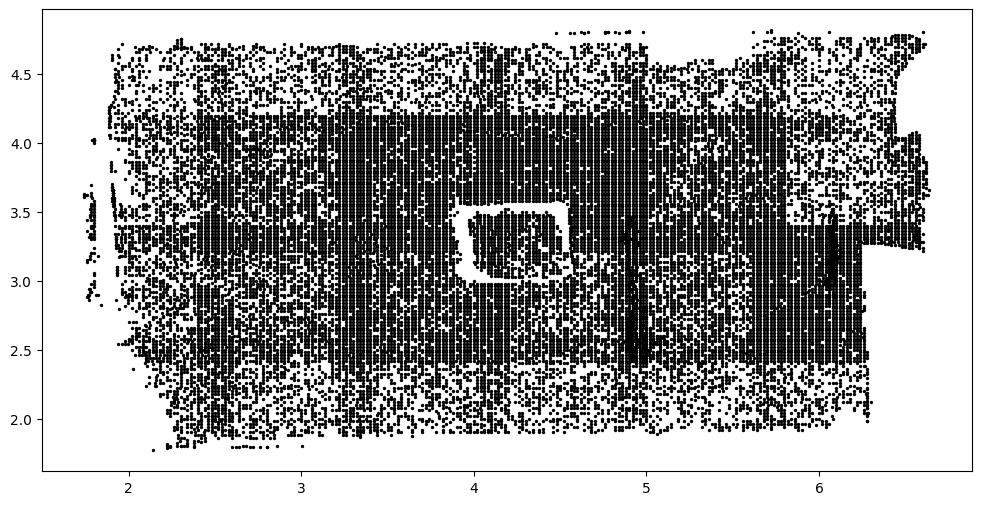

In [149]:
plt.figure(figsize=(12, 6))
plt.scatter(coord[:, 0], coord[:, 1], 
                    s=2, label=label, c=color if color else None)

In [144]:
def get_shape_dimensions_numpy(coordinates_array):
    if coordinates_array.size == 0:
        return 0, 0

    min_coords = np.min(coordinates_array, axis=0)
    max_coords = np.max(coordinates_array, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    return width, height

In [145]:
get_shape_dimensions_numpy(coord)

(np.float64(4.670390605926514), np.float64(3.1399996876716614))

In [ ]:
def rotation_to_align(g, target=np.array([0.,0.,-1.])):
    g = g / np.linalg.norm(g)
    t = target / np.linalg.norm(target)
    c = np.dot(g, t)
    if np.isclose(c, 1.0):
        return np.eye(3)
    if np.isclose(c, -1.0):
        # 180-degree rotation: pick arbitrary orthogonal axis
        # find vector orthogonal to g
        if abs(g[0]) < abs(g[1]):
            axis = np.array([1.,0.,0.])
        else:
            axis = np.array([0.,1.,0.])
        v = np.cross(g, axis)
        v = v / np.linalg.norm(v)
        # Rodrigues with angle = pi
        K = np.array([[0, -v[2], v[1]],
                      [v[2], 0, -v[0]],
                      [-v[1], v[0], 0]])
        return np.eye(3) + 2*(K @ K)  # since sin(pi)=0, 1-cos(pi)=2 -> simplifies
    v = np.cross(g, t)
    K = np.array([[0, -v[2], v[1]],
                  [v[2], 0, -v[0]],
                  [-v[1], v[0], 0]])
    R = np.eye(3) + K + K @ K * (1.0 / (1.0 + c))
    return R

# Example usage:
g = np.array([0.0036468, 0.0030084, -0.9999889])  # example gravity
R = rotation_to_align(g)
points_aligned = (points - points.mean(axis=0)) @ R.T  # center then rotate

np.int64(38)

In [ ]:
wall_indices = sem_seg.ransac_segmentor.segments['wall_pointnet']['indices']
# door_indices = sem_seg.ransac_segmentor.segments['door_pointnet']['indices']
# window_indices = sem_seg.ransac_segmentor.segments['window_pointnet']['indices']

print(f"Wall points: {len(wall_indices)}")
# print(f"Door points: {len(door_indices)}")
# print(f"Window points: {len(window_indices)}")

  

# Extract architectural points using indices
wall_points_2d = points_2d[wall_indices]
# door_points_2d = points_2d[door_indices]
# window_points_2d = points_2d[window_indices]

Wall points: 165476


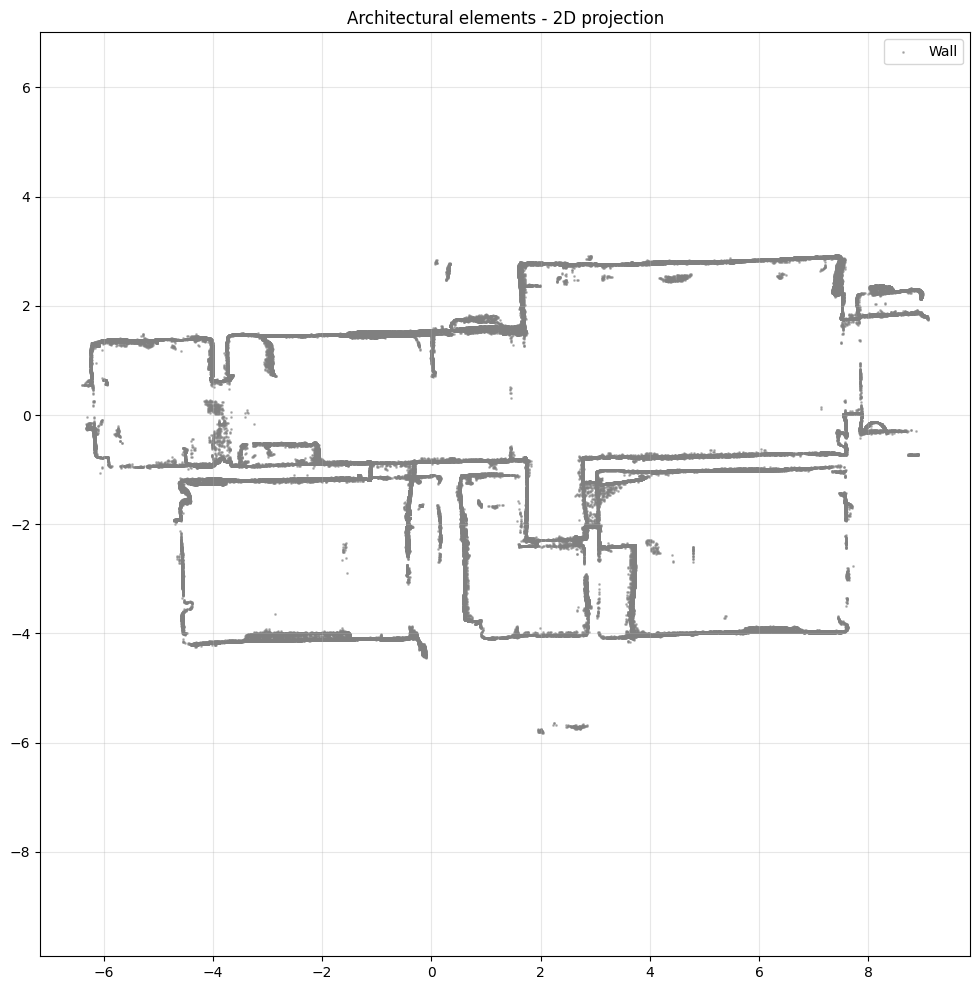

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [12]:
door_clusters = sem_seg.ransac_segmentor.cluster_points(door_indices, eps=0.5, )

In [13]:
for i, cluster in enumerate(door_clusters):
    print(i, len(cluster))

0 326
1 15
2 5062
3 12


In [14]:
door_indices_clustered = door_clusters[2]

In [15]:
wall_points_2d = points_2d[wall_indices]
door_points_2d = points_2d[door_indices_clustered]
# window_points_2d = points_2d[window_indices]

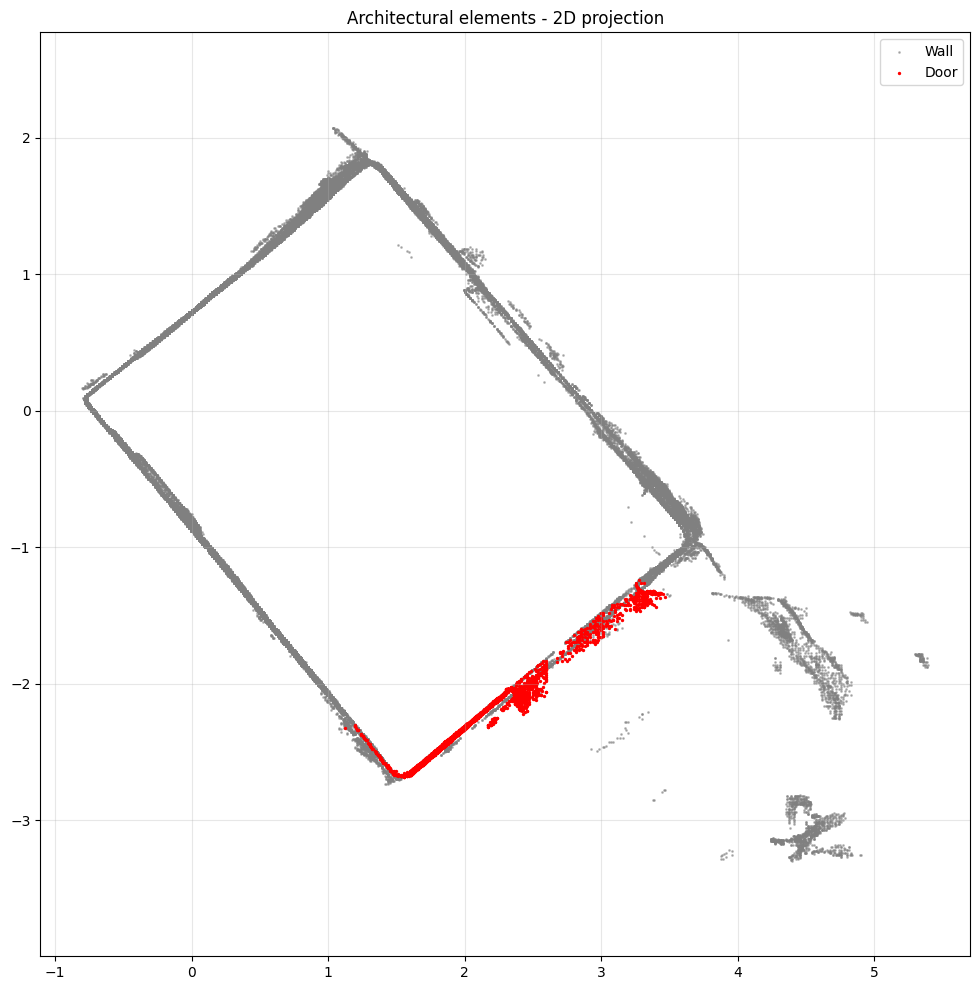

In [16]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [34]:
segment_models = {}
segments_ransac = {}

epsilon = 0.15
min_cluster_points = 50
max_plane_idx = 30
distance_threshold = 0.1
rest = sem_seg.pcd
for i in range(max_plane_idx):
    # colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=distance_threshold, ransac_n=3, num_iterations=2000)
    segments_ransac[i] = rest.select_by_index(inliers)
    labels = np.array(segments_ransac[i].cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
    candidates = [len(np.where(labels == j)[0]) for j in np.unique(labels)]
    best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])
    rest = rest.select_by_index(inliers, invert=True) + segments_ransac[i].select_by_index(list(np.where(labels != best_candidate)[0]))
    segments_ransac[i] = segments_ransac[i].select_by_index(list(np.where(labels == best_candidate)[0]))
    colors = plt.get_cmap("tab20")(i)
    segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # rest = rest.select_by_index(inliers, invert=True)
    
    # print("pass", i, "/", max_plane_idx, "done.")

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_28967/882629629.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])


In [35]:
o3d.visualization.draw_geometries([segments_ransac[i] for i in range(max_plane_idx)])

In [36]:
sem_seg.visualize_pcd()